In [ ]:
#created by sensei0410(IIT2022008) on 3/9/2023 for GeekHaven ML Competition
#text classification
#perform eda using pandas, use NLTK and sklearn to build the model

In [ ]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
train_df = pd.read_csv('/content/train.csv')
train_df.head()

In [ ]:
train_df['Emotion'].unique() #7 possible emotions for utterances

array(['neutral', 'sadness', 'anger', 'joy', 'disgust', 'fear',
       'surprise'], dtype=object)

In [ ]:
train_df.shape

(9595, 11)

In [ ]:
#using data visualization to see how the texts are distributed
train_df.groupby(['Emotion'])['Emotion'].count()

Emotion
anger       1164
disgust      255
fear         258
joy         1626
neutral     4441
sadness      715
surprise    1136
Name: Emotion, dtype: int64

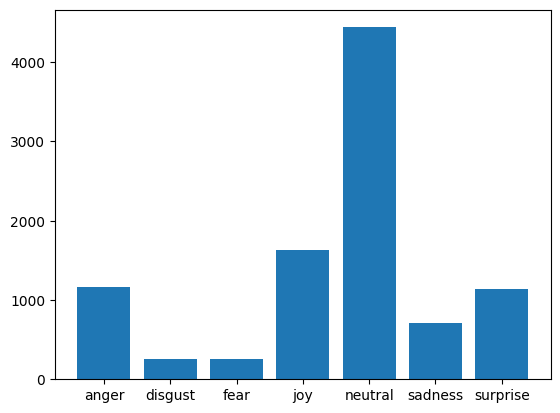

In [ ]:
#creating a dict will help in data viz
data = {'anger':1164,'disgust':255,'fear':258,'joy':1626,'neutral':4441,'sadness':715,'surprise':1136}
x = list(data.keys())
y = list(data.values())
plt.bar(x,y)
plt.show()
#from the graph we see that most of the data is categorized as neutral
#this might create the problem of overfitting the model can classify most new occurences as neutral

as there is a significant number of neutral occurences i will first try to
use undersampling. i will randomly delete a few occurences of neutral class to even things out, but first i will drop unnecesary columns

In [ ]:
train_df = train_df.drop(['Sr No.','Speaker','Dialogue_ID','Utterance_ID','Season',"Episode",'StartTime','EndTime'],axis=1)

In [ ]:
train_df.head()
#now we have only text and label

,Utterance,Sentiment,Emotion
0,Why don’t we do a trial run.,neutral,neutral
1,Y’know I don’t understand why they didn’t cry....,negative,sadness
2,Could've been a peach.,neutral,neutral
3,Uh-huh. But it was a first for the rest of my ...,neutral,neutral
4,This will be your phone.,neutral,neutral


In [ ]:
#upsampling disgust and fear to match the count of anger, the idea is to keep all classes to have almost the same count
#using the resample method in sklearn for this
from sklearn.utils import resample
anger_col = train_df[train_df['Emotion']=='anger']
fear_col = train_df[train_df['Emotion']=='fear']
disgust_col = train_df[train_df['Emotion']=='disgust']
disgust_new = resample(disgust_col,replace = True,n_samples = 1000,random_state = 42)
fear_new = resample(fear_col,replace = True,n_samples = 1000,random_state = 42)
train_df = pd.concat([train_df,disgust_new])
train_df = pd.concat([train_df,fear_new])

In [ ]:
train_df.groupby(['Emotion'])['Emotion'].count()

Emotion
anger       1164
disgust     1255
fear        1258
joy         1626
neutral     4441
sadness      715
surprise    1136
Name: Emotion, dtype: int64

In [ ]:
sadness_col = train_df[train_df['Emotion']=='sadness']
sadness_new = resample(sadness_col,replace = True,n_samples = 500,random_state = 42)
train_df= pd.concat([train_df,sadness_new])

In [ ]:
train_df.groupby(['Emotion'])['Emotion'].count()

Emotion
anger       1164
disgust     1255
fear        1258
joy         1626
neutral     4441
sadness     1215
surprise    1136
Name: Emotion, dtype: int64

In [ ]:
#to undersample neutral class
neutral_col = train_df[train_df['Emotion']=='neutral']
neutral_new = neutral_col.sample( n = 3183,replace = False,random_state = 42)
train_df = train_df.drop(neutral_new.index)

In [ ]:
#to undersample joy class
joy_col = train_df[train_df['Emotion']=='joy']
joy_new = joy_col.sample( n = 400,replace = False,random_state = 42)
train_df = train_df.drop(joy_new.index)

<Axes: xlabel='Emotion'>

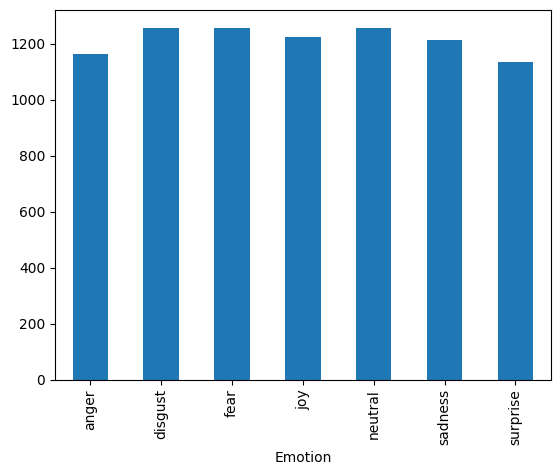

In [ ]:
new = train_df.groupby(['Emotion'])['Emotion'].count()
res_df = pd.DataFrame({'Count': new})
res_df.plot(kind= 'bar',legend = False)

In [ ]:
train_df.shape

(8512, 3)

In [ ]:
#we can create a feature cross between sentiment and emotion
#to do that we must first use label encoding to assign integer vals to labels in sentiment and emotion
#negative-> -1, neutral -> 1, positive -> 2
#anger-> 1, fear->2,disgust->3,neutral->4,sadness->5,joy->6,surprise->7

Sentiment_map = {'negative':-1,'neutral':1,'positive':2}
Emotion_map = {'anger':1,'fear':2,'disgust':3,'neutral':4,'sadness':5,'joy':6,'surprise':7}
train_df['Sentiment_Encoded'] = train_df['Sentiment'].map(Sentiment_map)
train_df['Emotion_Encoded'] = train_df['Emotion'].map(Emotion_map)

In [ ]:
#creating the feature cross
train_df['Sentiment_Emotion'] = train_df['Sentiment_Encoded']*train_df['Emotion_Encoded']
train_df.head()

,Utterance,Sentiment,Emotion,Sentiment_Encoded,Emotion_Encoded,Sentiment_Emotion
1,Y’know I don’t understand why they didn’t cry....,negative,sadness,-1,5,-5
4,This will be your phone.,neutral,neutral,1,4,4
5,Behind my brother's back? ... is exactly the ...,negative,anger,-1,1,-1
6,What?,neutral,neutral,1,4,4
7,I can't do it.,negative,sadness,-1,5,-5


Going to start using Natural Language Tool Kit (nltk) library for NLP now
starting with basic nlp

In [ ]:
#tokenizing, this will divide the input text into an individual words and return a list containing those words
from nltk import word_tokenize
def tokenize(input_str):
  tokenized_str = []
  for sent in input_str:
    tokenized_sent = word_tokenize(sent)
    tokenized_str.append(tokenized_sent)
  return tokenized_str #returns an array of arrays

In [ ]:
import nltk
nltk.download('all')

In [ ]:
#removing stop words (the words which dont have much meaning to the sentence)
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stop_words(tokenized_str): #as input is 2D array
  cleaned_token = []
  for item in tokenized_str:
    for word in item:
      if word not in stop_words:
        item.remove(word)
    cleaned_token.append(item)

  return cleaned_token #returns 2D array

In [ ]:
#testing the functions on the dialogues in the training data
tokenized_str = tokenize(train_df['Utterance'].tolist())

In [ ]:
cleaned_token = remove_stop_words(tokenized_str)

In [ ]:
train_df.head()

,Utterance,Sentiment,Emotion,Sentiment_Encoded,Emotion_Encoded,Sentiment_Emotion
1,Y’know I don’t understand why they didn’t cry....,negative,sadness,-1,5,-5
4,This will be your phone.,neutral,neutral,1,4,4
5,Behind my brother's back? ... is exactly the ...,negative,anger,-1,1,-1
6,What?,neutral,neutral,1,4,4
7,I can't do it.,negative,sadness,-1,5,-5


TF-IDF vectorizer to map strings to numbers followed by a support vector machine

vectorizer returns a matrix. the rows of the matrix correspond to each input string, the columns represent the word. and each entry into the matrix represents the number of times the word occured in the string.

A vectorizer first tokenizes the string and then counts the occurence of each word thus creating a dictionary of words and their value counts


In [ ]:
#train_df['Emotion_Encoded'].unique()
#train_df['Sentiment_Encoded'].unique()
train_df['Sentiment_Emotion'].unique()

array([-5,  4, -1, 12, -3, -2, -7, 14])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

text_input = train_df['Utterance']
y = train_df['Sentiment_Emotion'] #Sentiment_Emotion replaced with Emotion_Encoded
features = train_df[['Sentiment_Encoded']]

#split all 3 of the above columns
text_input_train,text_input_test,features_train,features_test,y_train,y_test = train_test_split(text_input,features,y,test_size = 0.2,random_state=42)

#TFIDF vectorizer for text_input
vectorizer = TfidfVectorizer()
text_input_train_tfidf = vectorizer.fit_transform(text_input_train) #fit_transform used for training data, converts strings to numerical matrix which represents the occurence of each word
text_input_test_tfidf = vectorizer.transform(text_input_test) #transform() used for testing, only transfoming because we dont want the model to learn on the test

#combining the train and test of the text_input with the encoded labels
train_input_combined = np.hstack((text_input_train_tfidf.toarray(),features_train)) #first converts the matrix from the vectorizer to an array and then combines the encoded labels to that new array
test_input_combined = np.hstack((text_input_test_tfidf.toarray(),features_test))

#using support vector machine for model
model = RandomForestClassifier()
model.fit(train_input_combined,y_train)

RandomForestClassifier()

In [ ]:
test_input_combined.shape

(1703, 3593)

In [ ]:
#testing the model
y_pred = model.predict(test_input_combined)
y_pred

array([12, 14, -2, ..., -1, -3, -2])

In [ ]:
#checking accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8220786846741045


In [ ]:
#to check with the testing dataset
test_df = pd.read_csv('/content/test (1).csv')
test_df.head()

,Sr No.,Utterance,Speaker,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,8267,"And before you know it, she's with him.",Joey,negative,869,11,3,12,"00:13:09,455","00:13:11,456"
1,6211,"Oh, oh, but y'know, you always see these reall...",Phoebe,neutral,652,13,1,6,"00:02:40,335","00:02:46,582"
2,10948,"Oh yeah? Hi, Ken Adams, nice to meet you.",Joey,neutral,95,3,8,4,"00:12:50,394","00:12:54,147"
3,8438,"But-but, Liam’s on my team.",Ross,positive,888,16,4,15,"00:17:03,355","00:17:05,064"
4,3190,Oh God!,Monica,negative,336,11,3,10,"00:12:48,184","00:12:49,225"


In [ ]:
test_df = test_df[['Utterance','Sentiment']]
test_df.head()

,Utterance,Sentiment
0,"And before you know it, she's with him.",negative
1,"Oh, oh, but y'know, you always see these reall...",neutral
2,"Oh yeah? Hi, Ken Adams, nice to meet you.",neutral
3,"But-but, Liam’s on my team.",positive
4,Oh God!,negative


In [ ]:
Sentiment_map = {'negative':-1,'neutral':1,'positive':2}
test_df['Sentiment_Encoded'] = test_df['Sentiment'].map(Sentiment_map)
test_df.head()

,Utterance,Sentiment,Sentiment_Encoded
0,"And before you know it, she's with him.",negative,-1
1,"Oh, oh, but y'know, you always see these reall...",neutral,1
2,"Oh yeah? Hi, Ken Adams, nice to meet you.",neutral,1
3,"But-but, Liam’s on my team.",positive,2
4,Oh God!,negative,-1


In [ ]:
features = test_df[['Sentiment_Encoded']]
features.shape

(4113, 1)

In [ ]:
test_input = vectorizer.transform(test_df['Utterance'])
test_input = test_input.toarray()
test_input.shape

(4113, 3592)

In [ ]:
test_combined = np.hstack((test_input,features))
test_combined.shape

(4113, 3593)

In [ ]:
final_pred= model.predict(test_combined)
final_pred.tolist()

In [ ]:
#map the predicted values back to their labels
#Emotion_map = {'anger':1,'fear':2,'disgust':3,'neutral':4,'sadness':5,'joy':6,'surprise':7}
for i in range(len(final_pred)):
  if final_pred[i]==-1:
    final_pred[i]=0
  if final_pred[i]==-3:
    final_pred[i]=1
  if final_pred[i]==-2:
    final_pred[i]=2
  if final_pred[i]==4:
    final_pred[i]=4
  if final_pred[i]==-5:
    final_pred[i]=5
  if final_pred[i]==12:
    final_pred[i]=3
  if final_pred[i]==14:
    final_pred[i]=6
  if final_pred[i]==-7:
    final_pred[i]=6

In [ ]:
for i in final_pred:
  print(i)

0
4
4
3
2
4
4
0
4
4
0
4
4
4
4
6
0
4
3
4
0
4
0
4
0
0
4
6
3
4
4
4
4
4
3
4
6
4
0
3
4
3
4
4
0
4
4
3
4
3
4
0
3
6
0
4
3
4
3
0
0
3
0
4
5
4
0
4
3
3
4
4
0
5
6
6
0
4
6
4
3
4
4
4
0
5
6
4
4
2
0
0
4
4
0
4
3
4
4
4
4
4
4
0
6
0
4
4
4
0
3
0
4
4
0
5
4
4
3
4
6
6
3
4
0
4
6
4
3
4
0
4
3
5
4
4
1
4
5
0
0
0
0
5
6
0
6
3
4
4
3
0
4
1
0
3
3
5
4
3
4
4
3
4
4
4
4
3
3
3
4
0
4
4
4
3
1
0
6
3
4
3
4
3
0
4
4
4
4
6
3
4
0
0
4
6
4
4
4
4
4
3
6
3
4
4
3
5
4
4
0
0
4
3
4
4
4
3
0
4
0
4
0
3
4
0
4
6
3
4
4
3
4
4
4
3
4
4
4
3
0
3
4
3
3
0
3
4
4
4
4
0
4
4
4
3
6
6
3
0
4
4
4
4
6
4
4
4
3
0
6
5
4
0
6
0
5
3
0
4
3
3
4
0
6
4
4
0
3
6
4
4
4
5
4
3
0
4
6
5
6
3
4
4
0
4
4
4
0
3
0
1
0
6
0
3
4
4
3
3
0
4
4
0
0
4
3
6
4
3
0
1
4
4
4
4
4
1
4
4
6
4
0
4
4
4
4
3
4
0
4
4
4
3
4
4
4
0
0
4
0
4
4
4
6
4
3
4
4
4
5
4
0
5
4
4
0
0
4
4
4
4
1
4
0
4
4
6
4
3
4
3
3
4
4
4
4
4
4
4
0
6
3
5
0
4
4
0
4
6
4
4
4
4
4
0
0
4
0
3
4
4
4
4
4
4
0
3
3
2
4
4
4
4
1
4
4
4
4
4
0
4
4
4
6
3
4
4
4
4
3
4
6
0
3
6
4
3
6
4
5
3
3
0
4
3
4
0
4
6
6
4
4
4
0
6
6
4
3
4
4
4
3
3
3
0
0
0
0
3
0
0
4
4
4
4
4
4
4
4
